In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from matplotlib.patches import Rectangle


%matplotlib inline

In [2]:
ds = xr.open_mfdataset('../data/dataset-satellite-sea-level-global/dt_global_twosat_phy_l4_*_vDT2021-M01.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:           (time: 368, nv: 2, latitude: 720, longitude: 1440)
Coordinates:
  * time              (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2023-08-15
  * latitude          (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude         (longitude) float32 0.125 0.375 0.625 ... 359.6 359.9
  * nv                (nv) int32 0 1
Data variables:
    crs               (time) int32 -2147483647 -2147483647 ... -2147483647
    climatology_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds          (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    eke               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         Delayed Time Level-4 monthly means of Se...
    time_coverage_duration:          P1M
    time_coverage_end:               1993-01-31T00:00:00Z
    time_coverage_resolution:        P1M
    time_coverage_start:             1993-01-01T00:00:00Z
    title:                           DT merged two-satellite Global Ocean L4 ...

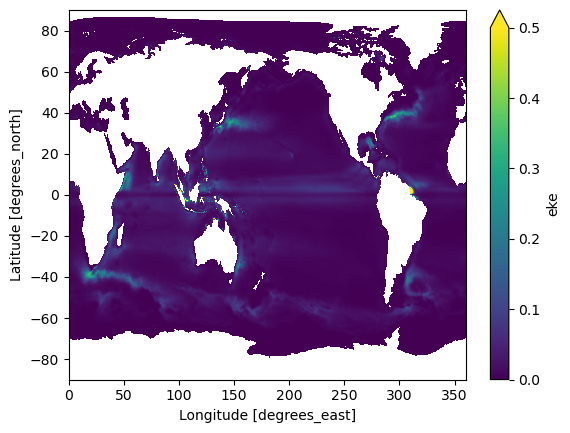

In [4]:
mean_eke = (ds.eke.mean('time')* 0.0001).load() # convert to m^2/s^2
mean_eke.plot(vmin=0,vmax=.5)


/Users/neilmalan/miniconda3/envs/wbc_compare/lib/python3.12/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


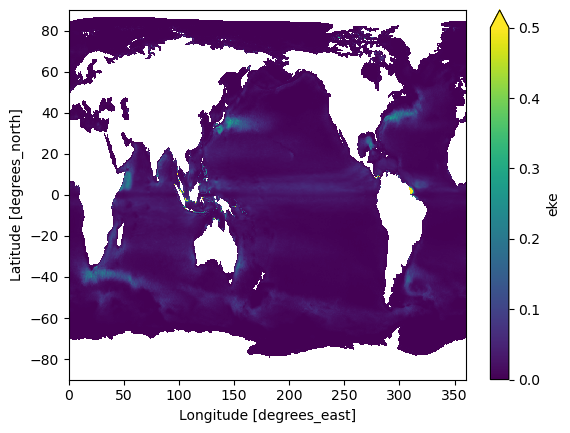

In [5]:
STD_eke = (ds.eke.std('time')* 0.0001).load() # convert to m^2/s^2
STD_eke.plot(vmin=0,vmax=.5)

In [6]:
def plot_eke(ax, mean_eke, vmin=0, vmax=0.4):
    """
    This function plots the mean EKE data in m^2/s^2 using Cartopy on the given Axes object.
    
    Parameters:
    ax (matplotlib.axes.Axes): The Axes object to plot on.
    mean_eke (xarray.DataArray): The mean EKE data to plot.
    vmin (float): Minimum value for colorbar.
    vmax (float): Maximum value for colorbar.
    """
    # Plot the data
    c = mean_eke.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),levels=9, vmin=vmin, vmax=vmax, cmap=cmo.amp, add_colorbar=False)
    
    # Add land with intermediate resolution
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='black', facecolor=cfeature.COLORS['land'])
    ax.add_feature(land, zorder=1)

    # Add borders using Cartopy's built-in BORDERS feature
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linestyle=':', zorder=2)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    
    return c

In [7]:
mean_eke_AC = mean_eke.sel(latitude=slice(-48, -20), longitude=slice(10, 45))
mean_eke_EAC = mean_eke.sel(latitude=slice(-48, -20), longitude=slice(145, 180))
mean_eke_BC = mean_eke.sel(latitude=slice(-48, -20), longitude=slice(290, 325))

mean_eke_GS = mean_eke.sel(latitude=slice(20, 48), longitude=slice(278, 313))
mean_eke_KC = mean_eke.sel(latitude=slice(20, 48), longitude=slice(130, 165))

In [8]:
STD_eke_AC = STD_eke.sel(latitude=slice(-48, -20), longitude=slice(10, 45))
STD_eke_EAC = STD_eke.sel(latitude=slice(-48, -20), longitude=slice(145, 180))
STD_eke_BC = STD_eke.sel(latitude=slice(-48, -20), longitude=slice(290, 325))

STD_eke_GS = STD_eke.sel(latitude=slice(20, 48), longitude=slice(278, 313))
STD_eke_KC = STD_eke.sel(latitude=slice(20, 48), longitude=slice(130, 165))

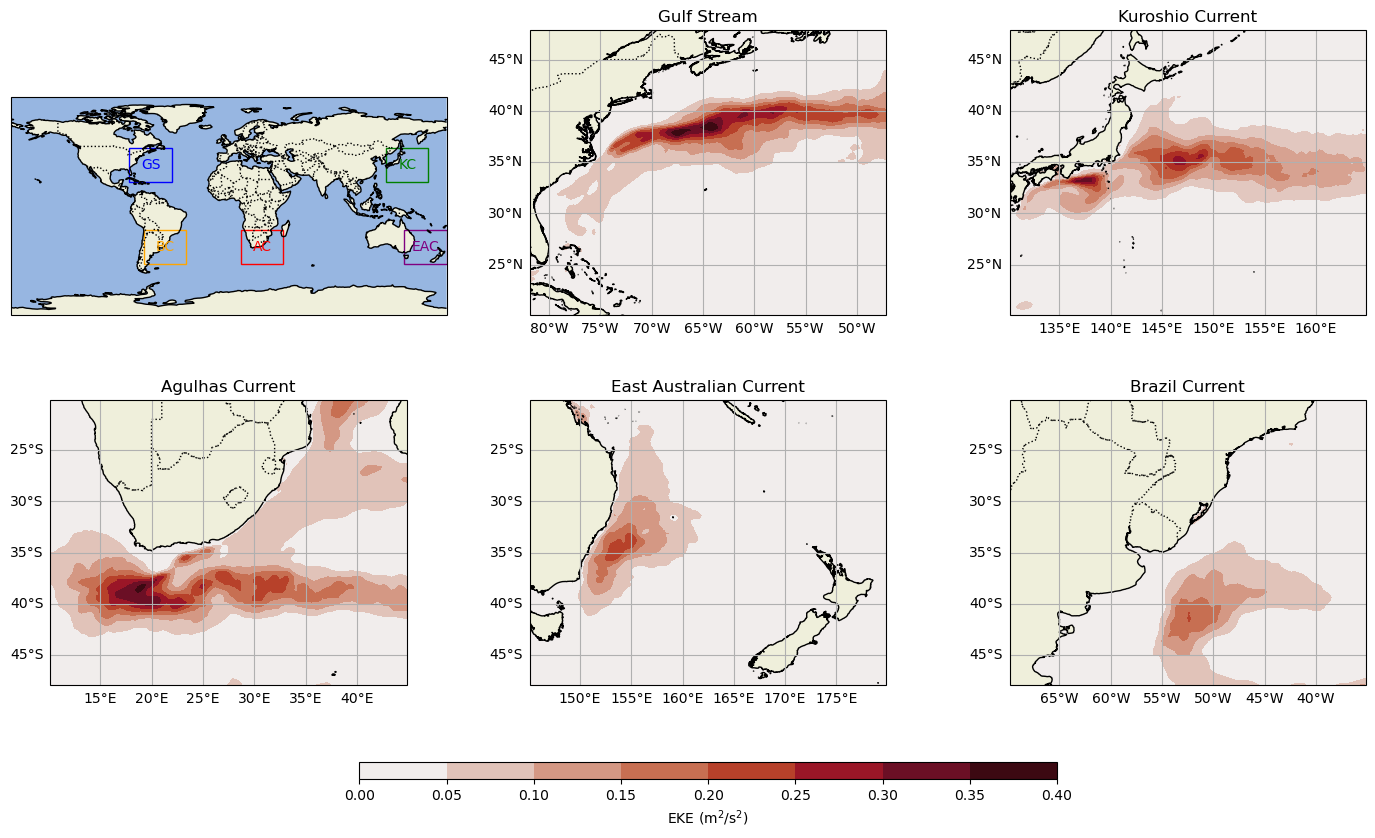

In [9]:
# Create the figure and subplots with adjusted column widths
fig, axs = plt.subplots(2, 3, figsize=(18, 10), 
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        gridspec_kw={'width_ratios': [1, 1, 1]})

# Adjust the spacing between plots
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Plot the world map in the top-left panel
axs[0, 0].set_extent([-180, 180, -90, 90])
axs[0, 0].add_feature(cfeature.LAND)
axs[0, 0].add_feature(cfeature.OCEAN)
axs[0, 0].add_feature(cfeature.COASTLINE)
axs[0, 0].add_feature(cfeature.BORDERS, linestyle=':')

# Define the locations and dimensions of the rectangles
regions = [
    {'label': 'GS', 'coords': [(278, 20), 35, 28], 'color': 'blue'},
    {'label': 'KC', 'coords': [(130, 20), 35, 28], 'color': 'green'},
    {'label': 'AC', 'coords': [(10, -48), 35, 28], 'color': 'red'},
    {'label': 'EAC', 'coords': [(145, -48), 35, 28], 'color': 'purple'},
    {'label': 'BC', 'coords': [(290, -48), 35, 28], 'color': 'orange'}
]

# Add rectangles for each region
for region in regions:
    (lon, lat), width, height = region['coords']
    rect = Rectangle((lon, lat), width, height, linewidth=1, edgecolor=region['color'], facecolor='none', transform=ccrs.PlateCarree())
    axs[0, 0].add_patch(rect)
    axs[0, 0].text(lon + width / 2, lat + height / 2, region['label'], color=region['color'], transform=ccrs.PlateCarree(),
                   horizontalalignment='center', verticalalignment='center')

# Plot each dataset
c1 = plot_eke(axs[0, 1], mean_eke_GS)
c2 = plot_eke(axs[0, 2], mean_eke_KC)
c3 = plot_eke(axs[1, 0], mean_eke_AC)
c4 = plot_eke(axs[1, 1], mean_eke_EAC)
c5 = plot_eke(axs[1, 2], mean_eke_BC)

# Add a single colorbar
cbar = fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1, aspect=40, shrink=0.5)
cbar.set_label(r'EKE ($\mathrm{m^2/s^2}$)')

# Set titles for the subplots
axs[0, 1].set_title('Gulf Stream')
axs[0, 2].set_title('Kuroshio Current')
axs[1, 0].set_title('Agulhas Current')
axs[1, 1].set_title('East Australian Current')
axs[1, 2].set_title('Brazil Current')

plt.savefig('../plots/WBC_mean_eke_plots.png', dpi=300, bbox_inches='tight')


## Plot STD of EKE

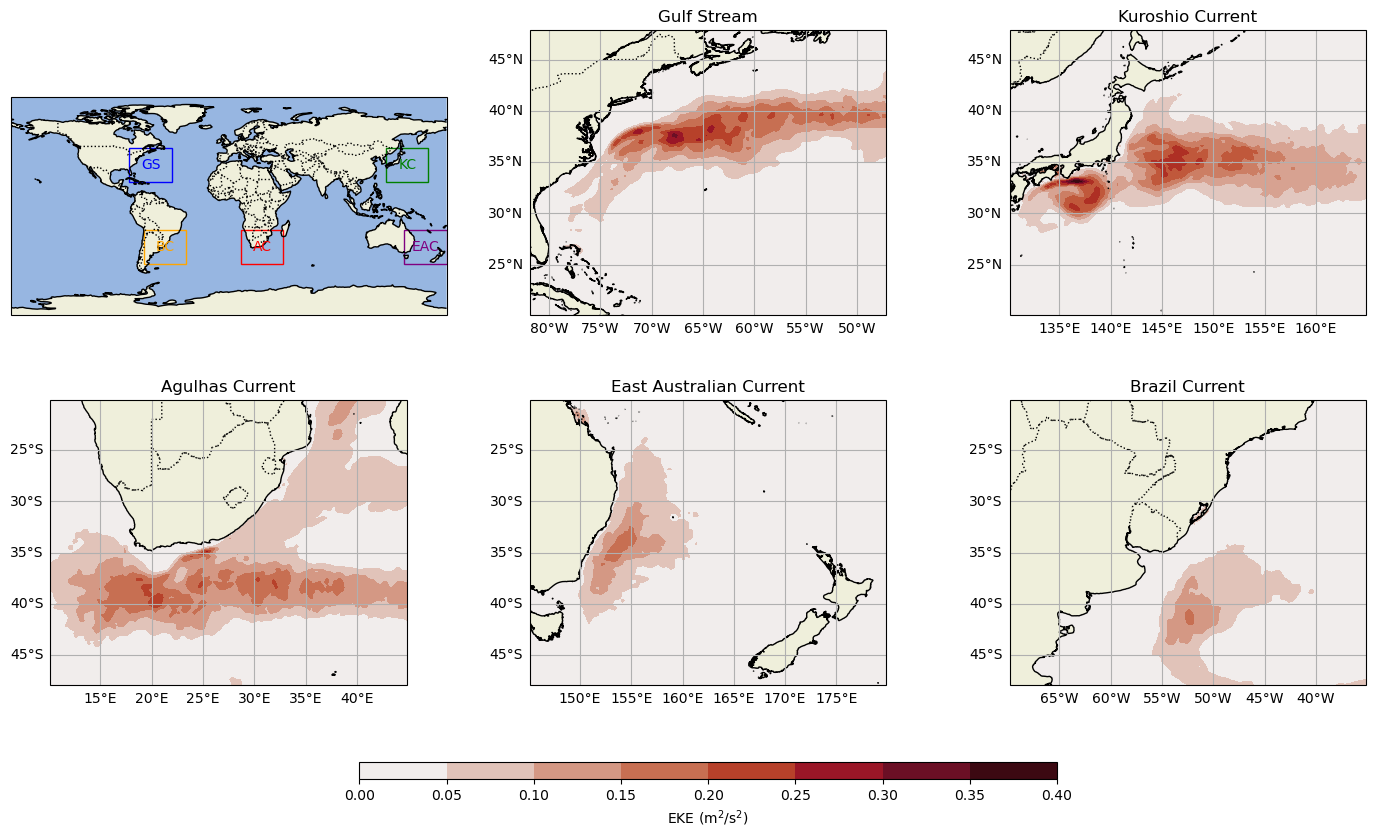

In [10]:
# Create the figure and subplots with adjusted column widths
fig, axs = plt.subplots(2, 3, figsize=(18, 10), 
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        gridspec_kw={'width_ratios': [1, 1, 1]})

# Adjust the spacing between plots
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Plot the world map in the top-left panel
axs[0, 0].set_extent([-180, 180, -90, 90])
axs[0, 0].add_feature(cfeature.LAND)
axs[0, 0].add_feature(cfeature.OCEAN)
axs[0, 0].add_feature(cfeature.COASTLINE)
axs[0, 0].add_feature(cfeature.BORDERS, linestyle=':')

# Define the locations and dimensions of the rectangles
regions = [
    {'label': 'GS', 'coords': [(278, 20), 35, 28], 'color': 'blue'},
    {'label': 'KC', 'coords': [(130, 20), 35, 28], 'color': 'green'},
    {'label': 'AC', 'coords': [(10, -48), 35, 28], 'color': 'red'},
    {'label': 'EAC', 'coords': [(145, -48), 35, 28], 'color': 'purple'},
    {'label': 'BC', 'coords': [(290, -48), 35, 28], 'color': 'orange'}
]

# Add rectangles for each region
for region in regions:
    (lon, lat), width, height = region['coords']
    rect = Rectangle((lon, lat), width, height, linewidth=1, edgecolor=region['color'], facecolor='none', transform=ccrs.PlateCarree())
    axs[0, 0].add_patch(rect)
    axs[0, 0].text(lon + width / 2, lat + height / 2, region['label'], color=region['color'], transform=ccrs.PlateCarree(),
                   horizontalalignment='center', verticalalignment='center')

# Plot each dataset
c1 = plot_eke(axs[0, 1], STD_eke_GS)
c2 = plot_eke(axs[0, 2], STD_eke_KC)
c3 = plot_eke(axs[1, 0], STD_eke_AC)
c4 = plot_eke(axs[1, 1], STD_eke_EAC)
c5 = plot_eke(axs[1, 2], STD_eke_BC)

# Add a single colorbar
cbar = fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1, aspect=40, shrink=0.5)
cbar.set_label(r'EKE ($\mathrm{m^2/s^2}$)')

# Set titles for the subplots
axs[0, 1].set_title('Gulf Stream')
axs[0, 2].set_title('Kuroshio Current')
axs[1, 0].set_title('Agulhas Current')
axs[1, 1].set_title('East Australian Current')
axs[1, 2].set_title('Brazil Current')

plt.savefig('../plots/WBC_STD_eke_plots.png', dpi=300, bbox_inches='tight')

## Ok, now let's get the averages from the LME shapefiles

In [21]:
import numpy as np
import xarray
import os
import scipy.signal as scipy_signal
import scipy.stats as scipy_stats
from geopy import distance as geo_dist
import cmocean
import pandas
import gsw as TEOS_10
import cartopy.feature as cfeature

20051.0 Central Kuroshio Current
20048.0 Northeastern Honshu


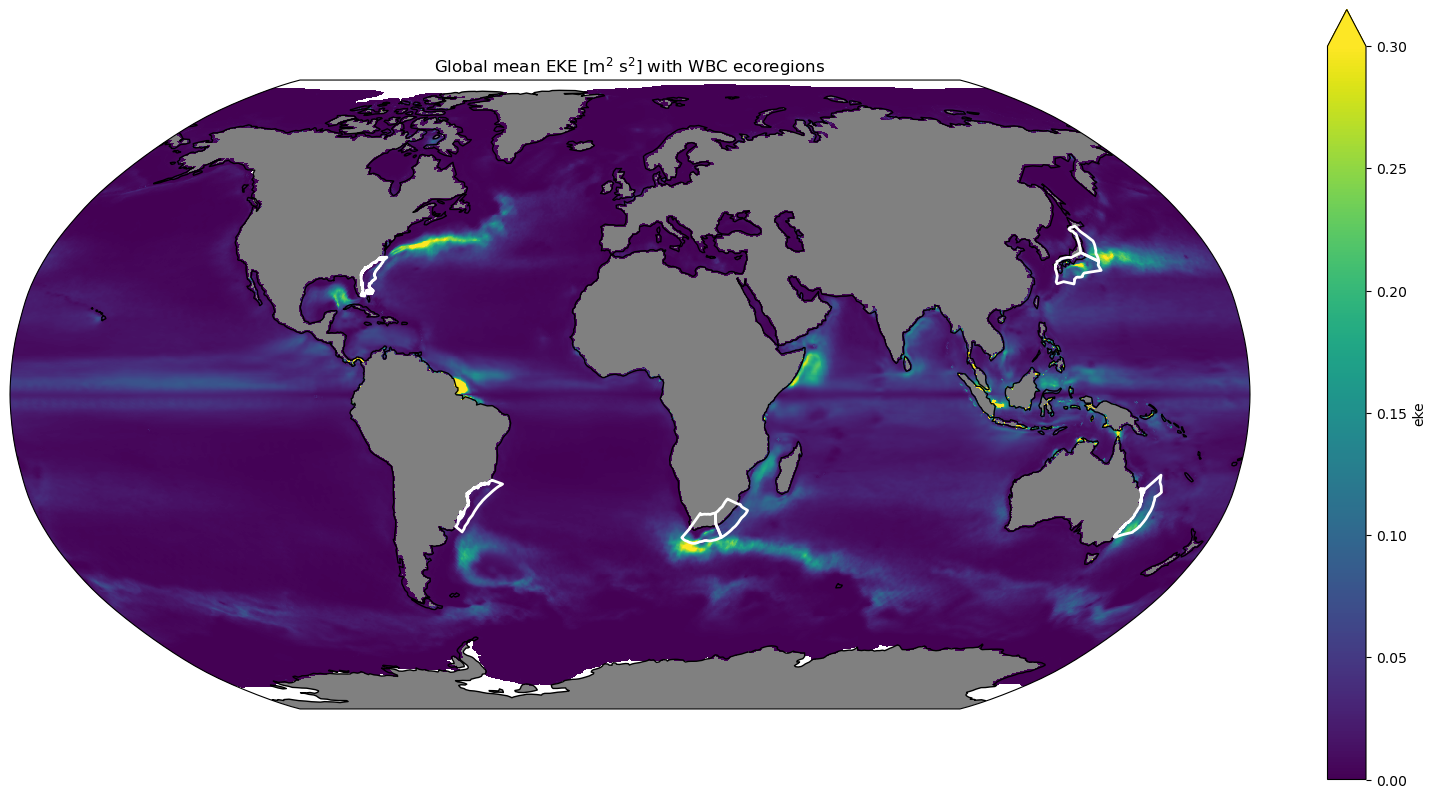

In [119]:
import geopandas as gpd
import cartopy.crs as ccrs
from cartopy.feature import LAND, COASTLINE

# Load shapefiles with Geopandas
SAU_LME_regions = gpd.read_file("../data/SAU_shapefiles/MEOW-subset-Jase.shp")
LME_regions = gpd.read_file("../data/SAU_shapefiles/LME-subset-Jase.shp")

# Define the projection (Robinson in this case)
proj = ccrs.Robinson()

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': proj})

# Set the land and coastline features
ax.add_feature(LAND, facecolor='grey')
ax.add_feature(COASTLINE, edgecolor='black')
mean_eke.plot(vmin=0, vmax=.3, ax=ax, transform=ccrs.PlateCarree())
# Codes to select specific regions
codes_to_get = [20192, 20193, 20051, 20048]

# Plot selected regions from SAU_LME_regions
for _, row in SAU_LME_regions.iterrows():
    eco_code = row['ECO_CODE']
    if 'Northwest Pacific' in row['PROVINCE']:
        print(eco_code, row['ECOREGION'])
    if int(eco_code) in codes_to_get:
        ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor="none",
                          edgecolor='white', alpha=1.0, linewidth=2.0)

# Plot selected regions from LME_regions
for _, row in LME_regions.iterrows():
    if row['LME_NAME'] in ['Southeast U.S. Continental Shelf', 'East Central Australian Shelf', 'South Brazil Shelf']:
        ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor="none",
                          edgecolor='white', alpha=1.0, linewidth=2.0)

# Optional: Adding a colorbar if you have data to display
# cbar = fig.colorbar(cs, ax=ax, ticks=[5000, 4000, 3000, 2000, 1000, 0], label='Depth (m)')
plt.title('Global mean EKE [m$^2$ s$^2$] with WBC ecoregions')

plt.savefig('mean_eke_with_ecoregions.png', dpi=400)
# plt.savefig(f"{figure_output_path}{figure_file_name}.pdf", dpi=200)

plt.show()


In [110]:
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.path as mpath
from shapely.geometry import mapping

# Load the shapefiles
SAU_LME_regions = gpd.read_file("../data/SAU_shapefiles/MEOW-subset-Jase.shp")
LME_regions = gpd.read_file("../data/SAU_shapefiles/LME-subset-Jase.shp")

# Define the regions to analyze from each shapefile
sau_regions_to_analyze = ['Agulhas Bank', 'Natal', 'Central Kuroshio Current', 'Northeastern Honshu']
lme_regions_to_analyze = ['Southeast U.S. Continental Shelf', 'East Central Australian Shelf', 'South Brazil Shelf']

# Function to align longitudes and latitudes in the DataArray
def align_coords(dataarray, lon_name, lat_name):
    dataarray = dataarray.assign_coords({lon_name: (dataarray[lon_name] + 360) % 360}).sortby(lon_name)
    return dataarray

# Align the coordinates in the mean_eke and STD_eke variables
mean_eke_aligned = align_coords(mean_eke, 'longitude', 'latitude')
std_eke_aligned = align_coords(std_eke, 'longitude', 'latitude')

# Function to mask inside boundaries and calculate the statistics
def mask_inside_boundaries(dataarray, shapereader_boundary_object, eco_codes_to_get, 
                           eco_region_key='LME_NAME', sensor_dims=['latitude', 'longitude'], 
                           shift_lons_to_n180_p180=True):
    y_coord = dataarray[sensor_dims[0]].values
    x_coord = dataarray[sensor_dims[1]].values

    if shift_lons_to_n180_p180:
        x_coord = np.where(x_coord > 180, x_coord - 360.0, x_coord)

    mask = np.zeros((y_coord.size, x_coord.size), dtype=bool)
    output_dict = {}

    for _, row in shapereader_boundary_object.iterrows():
        eco_region_name = row[eco_region_key].rstrip()

        if eco_region_name in eco_codes_to_get:
            # Adjust polygon longitude to [0, 360] range
            geometry = row.geometry
            point_coords = np.asarray([(lon % 360, lat) for lon, lat in geometry.exterior.coords])
            boundary_path = mpath.Path(point_coords, closed=True)
            x_points, y_points = np.meshgrid(x_coord, y_coord)

            mask = boundary_path.contains_points(np.hstack((x_points.flatten()[:, np.newaxis],
                                                            y_points.flatten()[:, np.newaxis])))
            mask = mask.reshape((y_coord.size, x_coord.size))

            # Convert mask to xarray DataArray with the same coordinates as the input dataarray
            mask_da = xr.DataArray(mask, dims=sensor_dims, coords={sensor_dims[0]: y_coord, sensor_dims[1]: x_coord})

            # Apply the mask to the dataarray
            dataarray_in_region = dataarray.where(mask_da)

            if dataarray_in_region.notnull().any():
                # Calculate the spatial average over latitude and longitude dimensions
                spatial_mean = dataarray_in_region.mean(dim=sensor_dims, skipna=True)

                output_dict[eco_region_name + '_value'] = float(spatial_mean.values)
            else:
                output_dict[eco_region_name + '_value'] = np.nan

    return output_dict

# Apply the function to mask the regions in the mean_eke and std_eke variables from both shapefiles
means_stats_sau = mask_inside_boundaries(mean_eke_aligned, SAU_LME_regions, sau_regions_to_analyze, 
                                         eco_region_key='ECOREGION', 
                                         sensor_dims=['latitude', 'longitude'], 
                                         shift_lons_to_n180_p180=False)

stds_stats_sau = mask_inside_boundaries(std_eke_aligned, SAU_LME_regions, sau_regions_to_analyze, 
                                        eco_region_key='ECOREGION', 
                                        sensor_dims=['latitude', 'longitude'], 
                                        shift_lons_to_n180_p180=False)

means_stats_lme = mask_inside_boundaries(mean_eke_aligned, LME_regions, lme_regions_to_analyze, 
                                         eco_region_key='LME_NAME', 
                                         sensor_dims=['latitude', 'longitude'], 
                                         shift_lons_to_n180_p180=False)

stds_stats_lme = mask_inside_boundaries(std_eke_aligned, LME_regions, lme_regions_to_analyze, 
                                        eco_region_key='LME_NAME', 
                                        sensor_dims=['latitude', 'longitude'], 
                                        shift_lons_to_n180_p180=False)

# Combine results from both shapefiles
output_dataframe = {
    'Agulhas_average': means_stats_sau.get('Agulhas Bank_value', np.nan) + means_stats_sau.get('Natal_value', np.nan),
    'Agulhas_2std': 2.0 * (stds_stats_sau.get('Northeastern Honshu_value', np.nan) + stds_stats_sau.get('Natal_value', np.nan)),
    
    'Gulf_stream_average': means_stats_lme.get('Southeast U.S. Continental Shelf_value', np.nan),
    'Gulf_stream_2std': 2.0 * stds_stats_lme.get('Southeast U.S. Continental Shelf_value', np.nan),
    
    'Kuroshio_average': means_stats_sau.get('Northeastern Honshu_value', np.nan) + means_stats_sau.get('Central Kuroshio Current_value', np.nan),
    'Kuroshio_2std': 2.0 * (stds_stats_sau.get('Northeastern Honshu_value', np.nan) + stds_stats_sau.get('Central Kuroshio Current_value', np.nan)),
    
    'EAC_average': means_stats_lme.get('East Central Australian Shelf_value', np.nan),
    'EAC_2std': 2.0 * stds_stats_lme.get('East Central Australian Shelf_value', np.nan),
    
    'Brazil_average': means_stats_lme.get('South Brazil Shelf_value', np.nan),
    'Brazil_2std': 2.0 * stds_stats_lme.get('South Brazil Shelf_value', np.nan)
}

# Convert to DataFrame
output_df = pd.DataFrame([output_dataframe], index=['EKE'])
print(output_df)

     Agulhas_average  Agulhas_2std  Gulf_stream_average  Gulf_stream_2std  \
EKE         0.146164      0.283378             0.030638          0.048011   

     Kuroshio_average  Kuroshio_2std  EAC_average  EAC_2std  Brazil_average  \
EKE          0.155403        0.35861     0.091522   0.14899        0.018549   

     Brazil_2std  
EKE     0.031235  


In [113]:
output_df.to_csv('../data/WBC_EKE_compendium.csv', index=False)  

In [120]:
ds

<xarray.Dataset>
Dimensions:           (time: 368, nv: 2, latitude: 720, longitude: 1440)
Coordinates:
  * time              (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2023-08-15
  * latitude          (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude         (longitude) float32 0.125 0.375 0.625 ... 359.6 359.9
  * nv                (nv) int32 0 1
Data variables:
    crs               (time) int32 -2147483647 -2147483647 ... -2147483647
    climatology_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds          (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    eke               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         Delayed Time Level-4 monthly means of Se...
    time_coverage_duration:          P1M
    time_coverage_end:               1993-01-31T00:00:00Z
    time_coverage_resolution:        P1M
    time_coverage_start:             1993-01-01T00:00:00Z
    title:                           DT merged two-satellite Global Ocean L4 ...